In [41]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

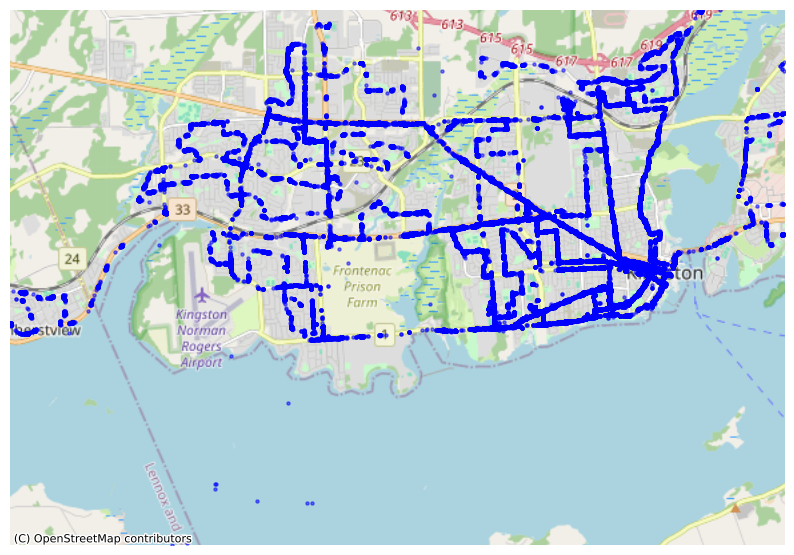

In [63]:
file_path = 'TransitData.csv'
data = pd.read_csv(file_path)
data = data[(data['Latitude'] != 0) & (data['Longitude'] != 0)]
lat_min, lat_max = 44.180, 44.300
lon_min, lon_max = -76.650, -76.450

# Filter out coordinates outside of Kingston
data = data[(data['Latitude'] >= lat_min) & (data['Latitude'] <= lat_max) & 
            (data['Longitude'] >= lon_min) & (data['Longitude'] <= lon_max)]

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.Longitude, data.Latitude))
gdf.crs = 'EPSG:4326'  # Set coordinate reference system to WGS 84

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=5, alpha=0.5)  # Convert to Web Mercator

# Define the map boundaries for Kingston, Ontario
xlim = ([min(gdf.to_crs(epsg=3857).geometry.x),
         max(gdf.to_crs(epsg=3857).geometry.x)])
ylim = ([min(gdf.to_crs(epsg=3857).geometry.y),
         max(gdf.to_crs(epsg=3857).geometry.y)])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)  # Add map basemap
ax.set_axis_off()
plt.show()

In [ ]:
bus_stops_df = pd.read_csv('civic-addresses.csv')  # Adjust the path to your file
addresses_df = pd.read_csv('transit-gtfs-stops.csv')  # Adjust the path as needed

print("Bus Stops DataFrame columns:", bus_stops_df.columns)
print("Addresses DataFrame columns:", addresses_df.columns)

Bus Stops DataFrame columns: Index(['ADDRESS_NUMBER', 'STREET_BODY_NAME', 'STREET_TYPE_SUFFIX',
       'DIRECTION_SUFFIX', 'ADDRESS_NUMBER_SUFFIX', '﻿"MUNICIPALITY"',
       'UNIT_TYPE', 'UNIT', 'STREET', 'FULL_ADDRESS', 'GARBAGE_DAY',
       'ELECTORAL_DISTRICT_NAME', 'NEIGHBOURHOOD', 'RECYCLING_DAY',
       'POSTAL_CODE', 'ADDRESS_ID', 'GeoJSON', 'LongLat'],
      dtype='object')
Addresses DataFrame columns: Index(['ID', 'Name', 'LongLat'], dtype='object')


In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Paths to your data files
file_path_houses = 'civic-addresses.csv'
file_path_bus_stops = 'TransitData.csv'

# Load the CSV files
bus_stops_df = pd.read_csv(file_path_bus_stops)
addresses_df = pd.read_csv(file_path_houses)

# For addresses_df, split the "long lat" column into two separate columns and convert to numeric
addresses_df[['Longitude', 'Latitude']] = addresses_df['LongLat'].str.split(',', expand=True).apply(pd.to_numeric, errors='coerce')

# Convert Longitude and Latitude columns to numeric for bus_stops_df
bus_stops_df['Longitude'] = pd.to_numeric(bus_stops_df['Longitude'], errors='coerce')
bus_stops_df['Latitude'] = pd.to_numeric(bus_stops_df['Latitude'], errors='coerce')

# Define the geographical boundaries for Kingston
lat_min, lat_max = 44.180, 44.300
lon_min, lon_max = -76.650, -76.450

# Filter out coordinates outside of Kingston and coordinates set to 0
addresses_df = addresses_df[(addresses_df['Latitude'] != 0) & (addresses_df['Longitude'] != 0) &
                            (addresses_df['Latitude'] >= lat_min) & (addresses_df['Latitude'] <= lat_max) & 
                            (addresses_df['Longitude'] >= lon_min) & (addresses_df['Longitude'] <= lon_max)]

bus_stops_df = bus_stops_df[(bus_stops_df['Latitude'] != 0) & (bus_stops_df['Longitude'] != 0) &
                            (bus_stops_df['Latitude'] >= lat_min) & (bus_stops_df['Latitude'] <= lat_max) & 
                            (bus_stops_df['Longitude'] >= lon_min) & (bus_stops_df['Longitude'] <= lon_max)]

# Convert DataFrames to GeoDataFrames
gdf_bus_stops = gpd.GeoDataFrame(bus_stops_df, geometry=gpd.points_from_xy(bus_stops_df.Longitude, bus_stops_df.Latitude))
gdf_addresses = gpd.GeoDataFrame(addresses_df, geometry=gpd.points_from_xy(addresses_df.Longitude, addresses_df.Latitude))

# Set CRS for GeoDataFrames to WGS84
gdf_bus_stops.crs = "EPSG:4326"
gdf_addresses.crs = "EPSG:4326"

# Prepare spatial index on the bus stops GeoDataFrame
sindex_bus_stops = gdf_bus_stops.sindex

# Find redundant bus stops within a specified threshold (e.g., 0.01 degrees, roughly 1 km)
threshold = 0.01  # Adjust based on your needs
redundant_bus_stops_indices = set()

for index, bus_stop in gdf_bus_stops.iterrows():
    # Find approximate matches with rtree spatial index (bounding box query)
    possible_matches_index = list(sindex_bus_stops.query(bus_stop.geometry.buffer(threshold), predicate="intersects"))
    possible_matches = gdf_bus_stops.iloc[possible_matches_index]

    # Exact distance check (for possible matches)
    for pm_index, possible_match in possible_matches.iterrows():
        if index != pm_index:  # Avoid comparing with itself
            distance = bus_stop.geometry.distance(possible_match.geometry)
            if distance <= threshold:  # If within threshold, add to redundant list
                redundant_bus_stops_indices.add(tuple(sorted([index, pm_index])))

# Extract unique indices of redundant bus stops (flattening the tuple set and getting unique indices)
unique_redundant_indices = set([index for pair in redundant_bus_stops_indices for index in pair])

# Print or save the redundant bus stops
print("Redundant Bus Stops (by index):", unique_redundant_indices)


KeyboardInterrupt: 

![Kingston Population Density](451ASS1/Density.png)

22640
11,110

In [ ]:
file_path = 'houses_with_nearest_bus_stops.csv'  # Update this to your actual file path
print("Bus Stops DataFrame columns:", file_path.columns)

AttributeError: 'str' object has no attribute 'columns'

In [ ]:
import pandas as pd

# Path to your data file
file_path = 'houses_with_nearest_bus_stops.csv'  # Update this to your actual file path




# Load the CSV file
df = pd.read_csv(file_path)

# Assume the CSV has 'DrivewayID', 'BusStopID', and 'Distance' columns
# You can adjust column names based on your actual file structure

# Define a distance threshold for "closeness" (e.g., 500 meters)
distance_threshold = 500  # Adjust based on your criteria

# Filter driveways that are within the threshold distance to a bus stop
close_driveways = df[df['distance_to_nearest_bus_stop_m'] <= distance_threshold]

# Find potentially redundant bus stops (those serving the least number of driveways)
# Count how many driveways are within the threshold distance for each bus stop
bus_stop_counts = close_driveways['nearest_bus_stop_index'].value_counts()

# Identify bus stops considered redundant based on a criterion, e.g., serving <= 2 driveways
# This criterion is arbitrary and should be adjusted based on your specific needs
redundant_bus_stops = bus_stop_counts[bus_stop_counts <= 2]

print("Potentially Redundant Bus Stops (serving <= 2 driveways):")
print(redundant_bus_stops)


Potentially Redundant Bus Stops (serving <= 2 driveways):
nearest_bus_stop_index
535    2
394    2
29     2
276    2
31     2
381    2
383    2
231    2
688    2
132    2
537    2
829    2
776    2
775    1
662    1
690    1
288    1
566    1
757    1
681    1
415    1
691    1
279    1
574    1
694    1
821    1
561    1
Name: count, dtype: int64


In [ ]:
import pandas as pd

# Path to your data file
file_path = 'houses_with_nearest_bus_stops.csv'  # Update this to your actual file path

# Load the CSV file
df = pd.read_csv(file_path)

# Assuming the CSV has columns for 'HouseID', 'BusStopID', and 'Distance'
# No need for a distance threshold here since we're just counting houses per bus stop

# Count how many houses are served by each bus stop
houses_per_bus_stop = df['nearest_bus_stop_index'].value_counts()

# Identify bus stops serving less than 20 houses
bus_stops_serving_less_than_20 = houses_per_bus_stop[houses_per_bus_stop < 20]

print("Bus Stops Serving Less Than 20 Houses:")
print(bus_stops_serving_less_than_20)


Bus Stops Serving Less Than 20 Houses:
nearest_bus_stop_index
361    19
421    19
525    19
755    19
200    18
       ..
681     1
574     1
566     1
415     1
561     1
Name: count, Length: 163, dtype: int64


In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = 'houses_with_nearest_bus_stops.csv'  # Make sure to adjust this path
df = pd.read_csv(file_path)

# Assuming 'Distance' is in meters and we consider any house within 500m to be "served"
distance_threshold = 500
close_driveways = df[df['distance_to_nearest_bus_stop_m'] <= distance_threshold]

# Count driveways close to each bus stop
close_counts = close_driveways['nearest_bus_stop_index'].value_counts()

# Bus stops serving <= 2 driveways within threshold
bus_stops_2_or_less = close_counts[close_counts <= 2].index.tolist()

# Count total houses served by each bus stop regardless of distance
total_counts = df['nearest_bus_stop_index'].value_counts()

# Bus stops serving < 20 houses
bus_stops_less_than_20 = total_counts[total_counts < 20].index.tolist()

# Find bus stops that are in both lists
common_bus_stops = list(set(bus_stops_2_or_less) & set(bus_stops_less_than_20))

# Filter original DataFrame for these bus stops to plot
bus_stops_to_plot = df[df['nearest_bus_stop_index'].isin(common_bus_stops)]

# Assuming 'Longitude' and 'Latitude' are for the bus stops in the original df
# This might need adjusting based on your data structure
##gdf = gpd.GeoDataFrame(bus_stops_to_plot, geometry=gpd.points_from_xy(bus_stops_to_plot['Longitude'], bus_stops_to_plot['Latitude']))

# Set CRS to WGS84
##gdf.crs = "EPSG:4326"

# Print total count of unique bus stops meeting criteria
print(f"Total unique bus stops meeting criteria: {len(common_bus_stops)}")


Total unique bus stops meeting criteria: 27


In [ ]:
import pandas as pd

# Load the CSV file
file_path = 'houses_with_nearest_bus_stops.csv'  # Adjust with your actual file path
df = pd.read_csv(file_path)

# Assuming 'Distance' is in meters and we consider any house within 500m to be "served"
distance_threshold = 500
close_driveways = df[df['distance_to_nearest_bus_stop_m'] <= distance_threshold]

# Count driveways close to each bus stop
close_counts = close_driveways['nearest_bus_stop_index'].value_counts()

# Bus stops serving <= 2 driveways within threshold
bus_stops_2_or_less = close_counts[close_counts <= 2].index.tolist()

# Count total houses served by each bus stop regardless of distance
total_counts = df['nearest_bus_stop_index'].value_counts()

# Bus stops serving < 20 houses
bus_stops_less_than_20 = total_counts[total_counts < 20].index.tolist()

# Find bus stops that are in both lists
common_bus_stops = list(set(bus_stops_2_or_less) & set(bus_stops_less_than_20))

# Assuming you want to print out details of these bus stops
# If 'Longitude' and 'Latitude' are in the original df, this will print their locations
bus_stops_details = df[df['nearest_bus_stop_index'].isin(common_bus_stops)][['nearest_bus_stop_index']].drop_duplicates()

print(f"Total unique bus stops meeting criteria: {len(common_bus_stops)}")
print("Bus Stops Details (ID):")
print(bus_stops_details.to_string(index=False))
bus_stops_details['nearest_bus_stop_index'].drop_duplicates().to_csv('unique_bus_stop_ids.csv', index=False)

Total unique bus stops meeting criteria: 27
Bus Stops Details (ID):
 nearest_bus_stop_index
                    381
                     29
                    415
                    566
                    535
                    691
                    688
                    132
                    279
                    821
                    276
                    288
                    694
                    574
                    537
                    231
                    681
                    757
                    394
                    776
                    775
                     31
                    662
                    383
                    690
                    829
                    561


In [ ]:
bus_stops_df = pd.read_csv('busstops.csv')
df = pd.DataFrame(bus_stops_df)
# Remove leading zeros and letters
df['ID'] = df['ID'].str.replace('^[0\D]+', '', regex=True)
df.to_csv('busstops.csv', index=False)
print(df)

       ID  Code                                            Name   
0    2077   NaN      Cataraqui Centre Transfer Point Platform 1  \
1     842   NaN         O'Connor Drive (east side of Gardiners)   
2     841   NaN           Norris Court (east side of Gardiners)   
3     848   NaN          640 Cataraqui Woods Drive (south side)   
4     856   NaN             1341 Crossfield Avenue (south side)   
..    ...   ...                                             ...   
825  9105   NaN  Midland Avenue (north side of Cataraqui Woods)   
826  9107   NaN   Juniper Drive (north side of Cataraqui Woods)   
827   445   NaN     First Canada Avenue (West side of Division)   
828   782   NaN           Warne Crescent (south side of Dalton)   
829   783   NaN      Lappan's Lane (north side of John Counter)   

                             Coordinates  Description  Zone ID  URL   
0                    44.25508, -76.57215          NaN      NaN  NaN  \
1                    44.25971, -76.56851          NaN

In [53]:
# Ensure the 'ID' column in bus_stops_df is the correct type, matching the 'bus_stop_id' column in unique_bus_stop_ids
bus_stops = pd.read_csv('busstops.csv')
unique_bus_stop_ids = pd.read_csv('unique_bus_stop_ids.csv')
bus_stops_df['ID'] = bus_stops_df['ID'].astype(str)
unique_bus_stop_ids['bus_stop_id'] = unique_bus_stop_ids['bus_stop_id'].astype(str)

# Now, perform the filter operation
filtered_bus_stops = bus_stops_df[bus_stops_df['ID'].isin(unique_bus_stop_ids['bus_stop_id'])]

# Check if filtered_bus_stops is empty
if filtered_bus_stops.empty:
    print("No bus stops match the criteria after filtering.")
else:
    print(f"Filtered bus stops: {len(filtered_bus_stops)}")

bus_stops_df[['Longitude', 'Latitude']] = bus_stops_df['LongLat'].str.strip().str.split(',', expand=True)
bus_stops_df['Longitude'] = pd.to_numeric(bus_stops_df['Longitude'].str.strip(), errors='coerce')
bus_stops_df['Latitude'] = pd.to_numeric(bus_stops_df['Latitude'].str.strip(), errors='coerce')

Filtered bus stops: 20


In [56]:
import pandas as pd

# Load the CSV files
bus_stops = pd.read_csv('busstops.csv')  # Assuming the file is in the same directory
unique_bus_stop_ids = pd.read_csv('unique_bus_stop_ids.csv')  # Update the path if necessary

# Make sure 'ID' in bus_stops and 'bus_stop_id' in unique_bus_stop_ids are the same type
bus_stops['ID'] = bus_stops['ID'].astype(str)
unique_bus_stop_ids['bus_stop_id'] = unique_bus_stop_ids['bus_stop_id'].astype(str)

# Filter bus_stops for these unique IDs
filtered_bus_stops = bus_stops[bus_stops['ID'].isin(unique_bus_stop_ids['bus_stop_id'])]

# Check if filtered_bus_stops is empty
if filtered_bus_stops.empty:
    print("No bus stops match the criteria after filtering.")
else:
    # Split 'LongLat' into separate 'Longitude' and 'Latitude' columns for the filtered DataFrame
    filtered_bus_stops[['Longitude', 'Latitude']] = filtered_bus_stops['Coordinates'].str.split(',', expand=True)
    
    # Convert the 'Longitude' and 'Latitude' strings to numeric values
    filtered_bus_stops['Longitude'] = pd.to_numeric(filtered_bus_stops['Longitude'], errors='coerce')
    filtered_bus_stops['Latitude'] = pd.to_numeric(filtered_bus_stops['Latitude'], errors='coerce')
    
    # Save the filtered bus stops with longitude and latitude to a new CSV file
    filtered_bus_stops.to_csv('filtered_bus_stops.csv', columns=['ID', 'Longitude', 'Latitude'], index=False)
    
    print(f"Filtered bus stops saved to 'filtered_bus_stops.csv'. Total bus stops: {len(filtered_bus_stops)}")


Filtered bus stops saved to 'filtered_bus_stops.csv'. Total bus stops: 20


/var/folders/ym/0_vtz1kx4_5fl0q9222rj5n40000gn/T/ipykernel_23865/3797728395.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_stops[['Longitude', 'Latitude']] = filtered_bus_stops['Coordinates'].str.split(',', expand=True)
/var/folders/ym/0_vtz1kx4_5fl0q9222rj5n40000gn/T/ipykernel_23865/3797728395.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_bus_stops[['Longitude', 'Latitude']] = filtered_bus_stops['Coordinates'].str.split(',', expand=True)
/var/folders/ym/0_vtz1kx4_5fl0q922

In [67]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Load the filtered bus stops data
file_path = 'filtered_bus_stops.csv'  # Update to the correct path
data = pd.read_csv(file_path)
display(data)




,ID,Longitude,Latitude
0,415,44.22134,-76.50893
1,662,44.25521,-76.58668
2,537,44.21842,-76.56733
3,681,44.24849,-76.60266
4,694,44.26656,-76.57826
5,31,44.23743,-76.59217
6,383,44.24531,-76.52038
7,381,44.24697,-76.52383
8,231,44.24371,-76.49515
9,288,44.24093,-76.49485


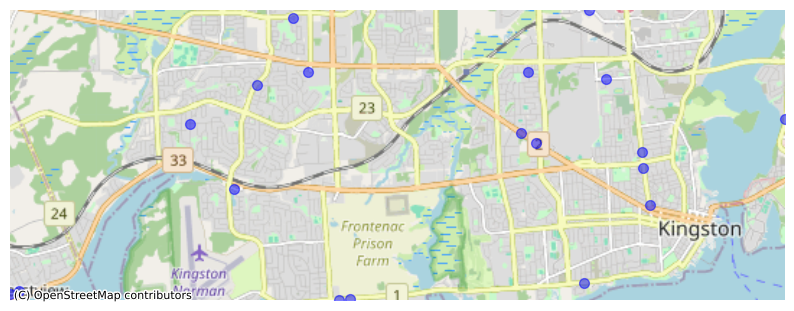

In [70]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Swap the 'Longitude' and 'Latitude' data, because they seem to be in the wrong order
filtered_bus_stops = filtered_bus_stops.rename(columns={"Longitude": "Latitude", "Latitude": "Longitude"})

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_bus_stops, geometry=gpd.points_from_xy(filtered_bus_stops.Longitude, filtered_bus_stops.Latitude))
gdf.crs = 'EPSG:4326'  # Set coordinate reference system to WGS 84

# Define geographical boundaries for Kingston, Ontario
lat_min, lat_max = 44.180, 44.300
lon_min, lon_max = -76.650, -76.450

# Filter for Kingston's geographical bounds
gdf = gdf.cx[lon_min:lon_max, lat_min:lat_max]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.to_crs(epsg=3857).plot(ax=ax, color='blue', markersize=50, alpha=0.5)  # Convert to Web Mercator

# Define the map boundaries for Kingston, Ontario, based on the filtered GeoDataFrame
xlim = ([min(gdf.to_crs(epsg=3857).geometry.x), max(gdf.to_crs(epsg=3857).geometry.x)])
ylim = ([min(gdf.to_crs(epsg=3857).geometry.y), max(gdf.to_crs(epsg=3857).geometry.y)])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.show()
